In [5]:
import matplotlib.pyplot as plt
import os
import torchaudio
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from adasp_data_management import music

import src.utils as utils
import src.models as models
import src.spectrograms as spec
import src.init as init

eps = 1e-6

### Load the ground truth dataset

In [2]:
# dataset_name    = "piano-dataset"
# dataset         = utils.NMFDataset(f"{dataset_name}/audios", f"{dataset_name}/midis", fixed_length=False, use_H=False, num_files=None)
# train_size      = 0.8

# train_set, valid_set = torch.utils.data.random_split(dataset, [train_size, 1-train_size])

# train_loader = DataLoader(train_set, batch_size=1, shuffle=False)
# valid_loader = DataLoader(valid_set, batch_size=1, shuffle=False)

In [3]:
maps = music.Maps("/tsi/mir/maps")
metadata = maps.pdf_metadata
dataset = utils.MapsDataset(metadata, fixed_length=False, subset=0.01)

Maps: load metadata file /tsi/mir/maps/metadata.csv


In [4]:
train_size      = 0.8

train_set, valid_set = torch.utils.data.random_split(dataset, [train_size, 1-train_size])

train_loader = DataLoader(train_set, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size=1, shuffle=False)
print(f"Train dataset: {len(train_loader)}, valid dataset: {len(valid_loader)}")

Train dataset: 288, valid dataset: 71


### Create the model
`hidden`=`8`, `shared`=`True` => 1122 params

In [5]:
W_path = 'test-data/synth-single-notes'
ralmu = models.RALMU(l=88, beta=1, W_path=W_path, n_iter=5, n_init_steps=1, hidden=8, shared=True, return_layers=False)
utils.model_infos(ralmu, names=False)
ralmu

The model has 1122 parameters


RALMU(
  (layers): ModuleList(
    (0-4): 5 x RALMU_block(
      (Aw): Aw_cnn(
        (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
        (conv2): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv3): Conv1d(8, 1, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.01)
        (softplus): Softplus(beta=1.0, threshold=20.0)
      )
      (Ah): Ah_cnn(
        (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
        (conv2): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv3): Conv1d(8, 1, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1

### Train the model

In [6]:
optimizer   = torch.optim.AdamW(ralmu.parameters(), lr=1e-2)
criterion   = nn.MSELoss()
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ralmu = ralmu.to(device)
epochs      = 20

train1 = False
n_epochs1 = 10
optimizer1 = torch.optim.AdamW(ralmu.parameters(), lr=1e-2)

# losses, W_warmup, H_warmup, H1 = utils.warmup_train(ralmu, n_epochs1, train_loader, optimizer1, device, debug=True)

losses, valid_losses, W_hat, H_hat = utils.train(ralmu, train_loader, optimizer, criterion, device, epochs, valid_loader)

# spec.vis_cqt_spectrogram(ralmu.W0, np.arange(ralmu.W0.shape[1]), np.arange(ralmu.W0.shape[0]), 0, ralmu.W0.shape[1])
# spec.vis_cqt_spectrogram(W_warmup.detach(), np.arange(W_warmup.shape[1]), np.arange(W_warmup.shape[0]), 0, W_warmup.shape[1])
# spec.vis_cqt_spectrogram(W_hat.detach(), np.arange(W_hat.shape[1]), np.arange(W_hat.shape[0]), 0, W_hat.shape[1])

plt.plot(losses[1:], label='train loss')
plt.plot(valid_losses[1:], label='valid loss')
plt.ylabel("MSE")
plt.xlabel("epochs")
plt.legend()

epoch 0, loss = 291416.843888
epoch 1, loss = 6.584222
epoch 2, loss = 7.002675
epoch 3, loss = 5.597723


KeyboardInterrupt: 

In [31]:
dataset_name = "piano-dataset"
y, sr = torchaudio.load(f"{dataset_name}/audios/example-6.wav")
M, times, _ = spec.cqt_spec(y, sr, hop_length=128)
midi, onset, offset, _ = spec.midi_to_pianoroll(f"{dataset_name}/midis/example-6.mid", y, times,128,sr)
active_midi = [i for i in range(88) if (midi[i, :] > 0).any().item()]
H = init.MIDI_to_H(midi, active_midi, onset, offset)

In [30]:
W_path = 'test-data/synth-single-notes'
model_path = 'models/RALMU.pt'
weights = torch.load(model_path)
weights.pop("H0")

ralmu = models.RALMU(l=88, beta=1, W_path=W_path, n_iter=5, n_init_steps=1, hidden=8, shared=True, return_layers=False)

ralmu.load_state_dict(weights)
ralmu.init_H(M)

W_hat, H_hat, M_hat = ralmu.forward(M)

In [32]:
print(utils.compute_metrics(H_hat, H))

(0.00014913353416649266, 0.47619047619047616, 0.0002981736861721953, 0.3125)


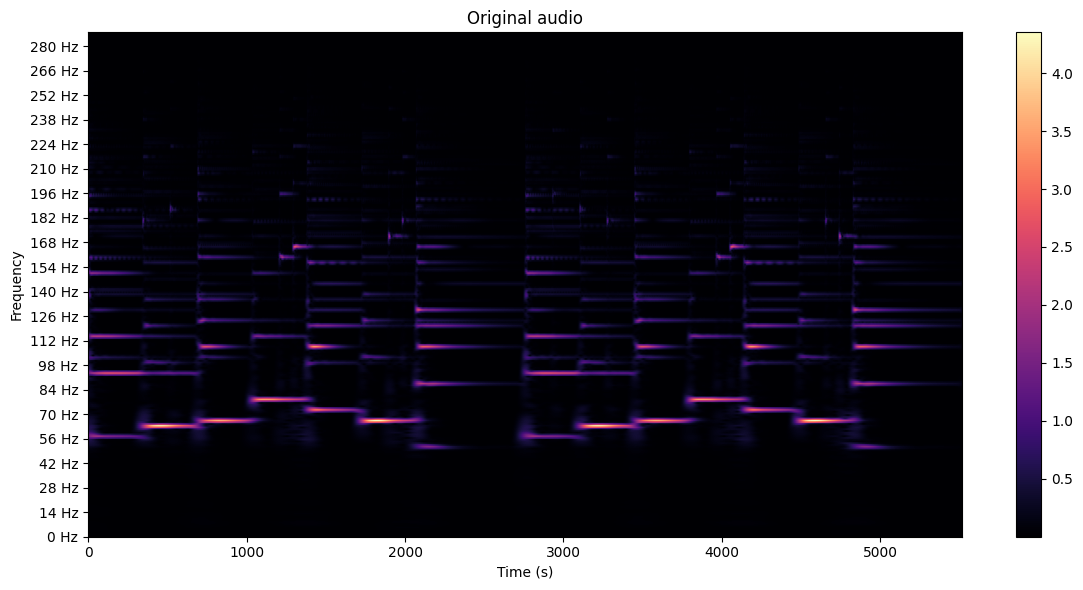

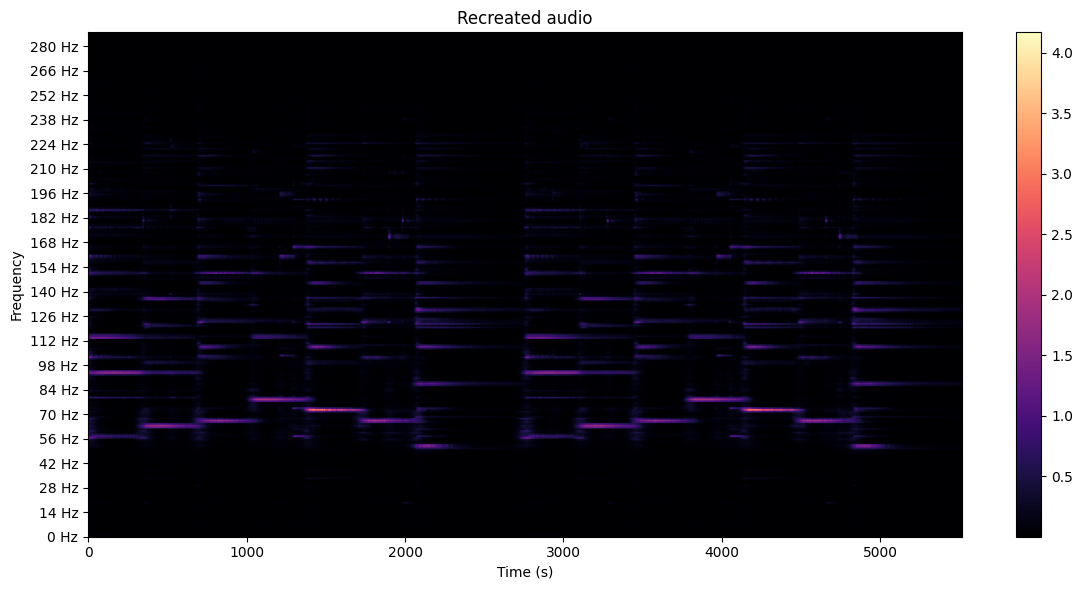

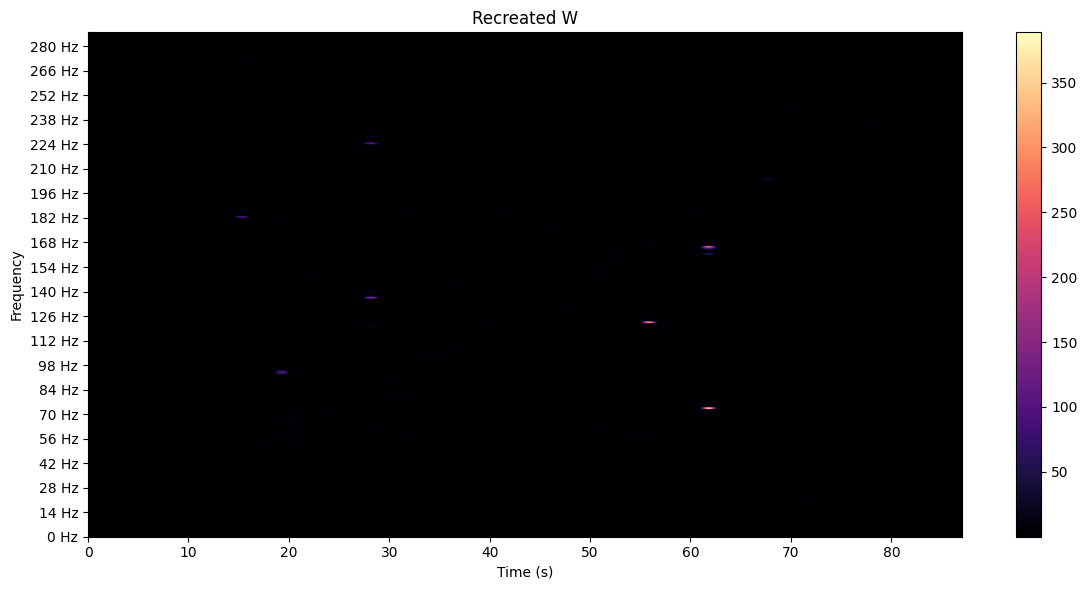

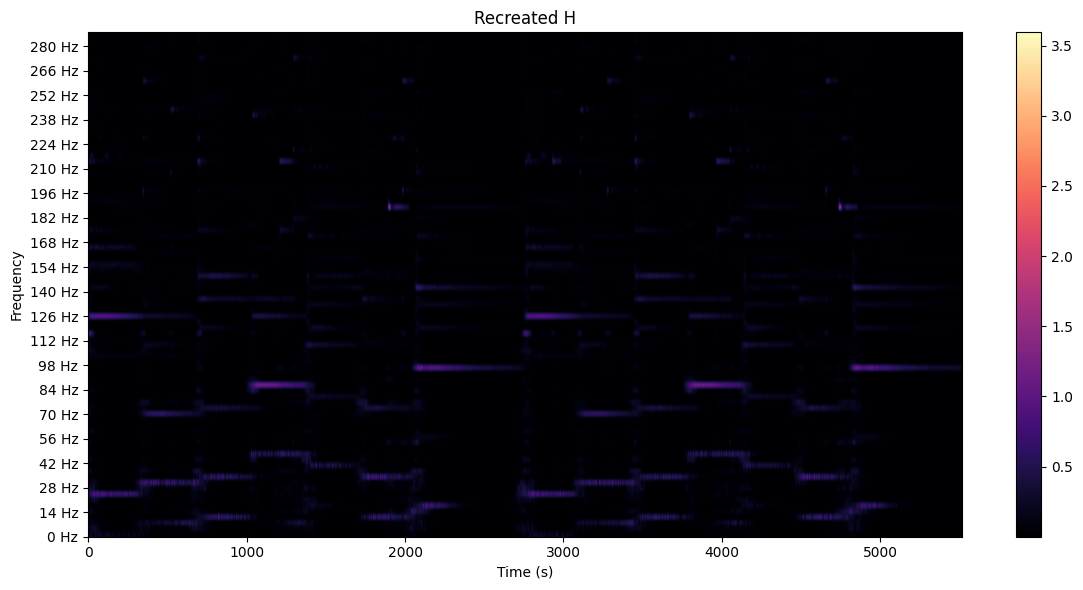

In [35]:
times = np.arange(M.shape[1])
freqs = np.arange(M.shape[0])

spec.vis_cqt_spectrogram(M, times, freqs, 0, times[-1], title="Original audio")
spec.vis_cqt_spectrogram(M_hat.detach(), times, freqs, 0, times[-1], title="Recreated audio")
spec.vis_cqt_spectrogram(W_hat.detach(), np.arange(88), freqs, 0, 88, title="Recreated W")
spec.vis_cqt_spectrogram(H_hat.detach(), times, freqs, 0, times[-1], title="Recreated H")